In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

In [5]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    df.drop(["Unnamed: 0", 'row_id'], axis=1, inplace=True)

    return df

In [6]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

In [7]:
date_set_path = "../temp_sets_100/"

In [8]:
labevents_sample_df = read_csv_no_rowid(date_set_path + "labevents.csv")

In [9]:
labevents_sample_df.head()

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,569,116412.0,50931,2105-02-24 05:30:00,226,226.0,mg/dL,abnormal
1,569,116412.0,50960,2105-02-24 05:30:00,1.9,1.9,mg/dL,NaN
2,569,116412.0,50970,2105-02-24 05:30:00,4.2,4.2,mg/dL,NaN
3,569,116412.0,50971,2105-02-24 05:30:00,3.4,3.4,mEq/L,NaN
4,569,116412.0,50983,2105-02-24 05:30:00,137,137.0,mEq/L,NaN


In [10]:
# Drop some null value
labevents_sample_df.dropna(subset=['subject_id', 'hadm_id'], inplace=True, axis=0)

In [11]:
# Drop some columns
labevents_sample_df.drop(['flag'], axis=1, inplace=True)

In [12]:
nan_count(labevents_sample_df)

Total columns: 7
Total rows: 44069
--------------
subject_id       0
hadm_id          0
itemid           0
charttime        0
value            0
valuenum      4032
valueuom      4398
dtype: int64


In [13]:
# Deal with null values
labevents_sample_df['value'].fillna(value='Na', inplace=True)
labevents_sample_df['valuenum'].fillna(value='Na', inplace=True)
labevents_sample_df['valueuom'].fillna(value='Na', inplace=True)

In [14]:
labevents_sample_df.dtypes

subject_id      int64
hadm_id       float64
itemid          int64
charttime      object
value          object
valuenum       object
valueuom       object
dtype: object

In [15]:
labevents_sample_df['hadm_id'] = labevents_sample_df['hadm_id'].astype(int)

labevents_sample_df['charttime'] = pd.to_datetime(labevents_sample_df['charttime'])

In [16]:
labevents_sample_df.dtypes

subject_id             int64
hadm_id                int32
itemid                 int64
charttime     datetime64[ns]
value                 object
valuenum              object
valueuom              object
dtype: object

In [17]:
len(labevents_sample_df)

44069

---

## Build model

In [18]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations
from sdv.constraints import Inequality

In [19]:
labevents_sample_df.columns

Index(['subject_id', 'hadm_id', 'itemid', 'charttime', 'value', 'valuenum',
       'valueuom'],
      dtype='object')

In [20]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id']
)
fixed_itemid_value_valueuom_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valuenum', 'valueuom']
)

In [21]:
labevents_constraints = [fixed_subject_hadm_icustay_constraint, fixed_itemid_value_valueuom_constraint]

In [22]:
model = CTGAN(
    constraints=labevents_constraints, 
    batch_size=1000,
    generator_lr=0.0005,
    discriminator_lr=0.0005,
    cuda=True, 
    verbose=True, 
    epochs=200)

In [23]:
len(labevents_sample_df)

44069

In [24]:
train_data = labevents_sample_df.loc[0:1000, : ]
model.fit(train_data)

Epoch 1, Loss G:  4.1719,Loss D: -0.0012
Epoch 2, Loss G:  4.1014,Loss D: -0.0002
Epoch 3, Loss G:  3.9764,Loss D: -0.0005
Epoch 4, Loss G:  4.1089,Loss D:  0.0049
Epoch 5, Loss G:  4.1273,Loss D: -0.0007
Epoch 6, Loss G:  3.9639,Loss D: -0.0088
Epoch 7, Loss G:  4.0288,Loss D: -0.0104
Epoch 8, Loss G:  4.0526,Loss D: -0.0152
Epoch 9, Loss G:  3.9669,Loss D: -0.0052
Epoch 10, Loss G:  4.0220,Loss D: -0.0058
Epoch 11, Loss G:  4.0231,Loss D:  0.0154
Epoch 12, Loss G:  3.9823,Loss D:  0.0155
Epoch 13, Loss G:  4.1040,Loss D:  0.0077
Epoch 14, Loss G:  3.8884,Loss D: -0.0060
Epoch 15, Loss G:  3.9409,Loss D: -0.0110
Epoch 16, Loss G:  4.0096,Loss D: -0.0210
Epoch 17, Loss G:  3.9895,Loss D: -0.0300
Epoch 18, Loss G:  3.9601,Loss D: -0.0425
Epoch 19, Loss G:  3.8699,Loss D: -0.0410
Epoch 20, Loss G:  3.9510,Loss D: -0.0222
Epoch 21, Loss G:  3.8054,Loss D: -0.0262
Epoch 22, Loss G:  3.8397,Loss D: -0.0055
Epoch 23, Loss G:  3.9288,Loss D:  0.0064
Epoch 24, Loss G:  3.6941,Loss D:  0.0263
E

In [25]:
model.save("../labevents_model.pkl")

In [26]:
# model = CTGAN.load(("/content/drive/MyDrive/MSc Project/labevents_model.pkl"))

In [27]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 788/788 [00:00<00:00, 10355.49it/s]


In [28]:
len(sample)

788

In [29]:
nan_count(sample)

Total columns: 7
Total rows: 788
--------------
subject_id    0
hadm_id       0
itemid        0
charttime     0
value         0
valuenum      0
valueuom      0
dtype: int64


In [30]:
sample.dtypes

subject_id             int64
hadm_id                int32
itemid                 int64
charttime     datetime64[ns]
value                 object
valuenum              object
valueuom              object
dtype: object

In [31]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.6708327536750832

In [32]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.5563518100543706

<AxesSubplot:xlabel='itemid', ylabel='value'>

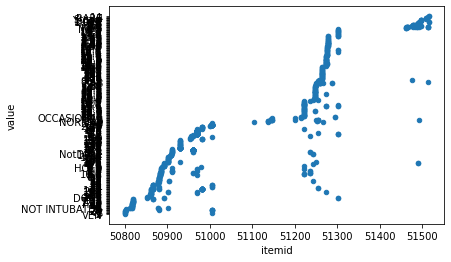

In [33]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

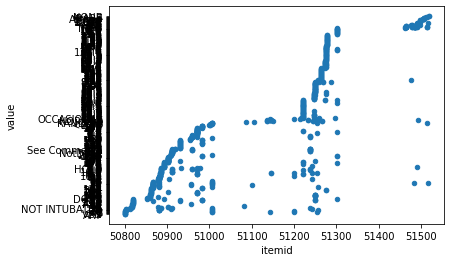

In [34]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:>

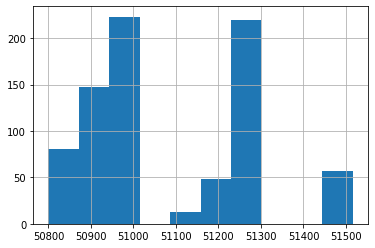

In [35]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

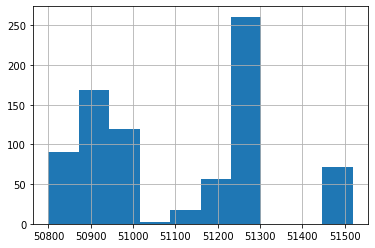

In [36]:
train_data.sort_values('itemid')['itemid'].hist()

In [37]:
# evaluate(sample, train_data, aggregate=False)